In [11]:
import numpy as np
import vast.io_mesh as io
import vast.surface_tools as st
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
def generate_prism(g_coords,w_coords,triangle):
    """return coordinates for prism in a dictionary
    with two triangles
    ordering is g1,g2,g3 - w1,w2,w3"""
    prism_coordinates={'g_triangle':g_coords[triangle],'w_triangle':w_coords[triangle]}
    return prism_coordinates

def prism_bounding_box(prism):
    """returns the two defining corners of a box enclosing the prism.
    i.e. the minimum and maximum values in the 3 dimensions."""
    return bounding_box(np.vstack((prism['g_triangle'],prism['w_triangle'])))

def bounding_box(coords):
    """calculate bounding box for input coordinates"""
    mins=np.min(coords,axis=0)
    maxs=np.max(coords,axis=0)
    return mins, maxs

def voxel_world_coords_in_box(box, origin_offset, voxel_resolution, dimensions):
    """calculate which voxels from a block/slice/volume are located a box (world coordinates)
    returns coordinates of voxels and voxel indices
    Assumes axis orderings of box, origin_offset, voxel resolution and dimensions are all the same
    Usually xyz"""
    #calculate box corners in voxel indices. Ensure voxel coordinates are non-negative and do not
    #exceed volume limits
    indices_min = np.min((np.max((np.floor((box[0] - origin_offset)/resolution),[0,0,0]),axis=0),dimensions),axis=0).astype(int)
    indices_max = np.min((np.max((np.ceil((box[1]- origin_offset)/resolution), [0,0,0]), axis=0),dimensions), axis=0).astype(int)
    if (indices_min == indices_max).all():
        #box not in volume block.
        #TODO test subsequent functionality
        return None, None
    
    #get a grid of coordinates
    voxel_coordinates=np.mgrid[indices_min[0]:indices_max[0],
         indices_min[1]:indices_max[1],
        indices_min[2]:indices_max[2]].T
    voxel_coordinates = np.reshape(voxel_coordinates,(voxel_coordinates.size//3,3))
    #convert to world coordinates
    world_coordinates=origin_offset+voxel_coordinates*resolution
    return world_coordinates, voxel_coordinates.astype(int)

def get_exact_depth(voxel_coord, prism, decimals=5):
    """returns exact coortical depth of point
    
    due to imprecisions in estimating roots of the cubic, it is advisable to round to desired accuracy.
    for 3mm cortex, decimals=5 gives an accuracy of 30 nanometers"""
    #solve for depth
    connecting_vectors = prism['w_triangle']-prism['g_triangle']
    connecting_inplane_vectors = np.array([connecting_vectors[2]-connecting_vectors[0],
                                           connecting_vectors[1]-connecting_vectors[0]])
    #k2 term of cp
    cross_product_connecting_vectors = np.cross(connecting_inplane_vectors[0],connecting_inplane_vectors[1])

    gray_inplane_vectors = np.array([prism['g_triangle'][2]-prism['g_triangle'][0],
                                     prism['g_triangle'][1]-prism['g_triangle'][0]])
    #const term of cp
    cross_product_gray_inplane_vectors = np.cross(gray_inplane_vectors[0],gray_inplane_vectors[1])

    #k term of cp
    cross_prod_gray_connecting1 = np.cross(gray_inplane_vectors[1], connecting_inplane_vectors[0])
    cross_prod_gray_connecting2 = np.cross(gray_inplane_vectors[0], connecting_inplane_vectors[1])
    cross_prod_gray_connecting_sum = -cross_prod_gray_connecting1+cross_prod_gray_connecting2

    g3 = prism['g_triangle'][2]
    v3 = connecting_vectors[2]

    k3 = np.dot(cross_product_connecting_vectors,v3)
    k2 = (np.dot(v3,cross_prod_gray_connecting_sum)+
         np.dot(cross_product_connecting_vectors,g3-voxel_coord))
    k1 = (np.dot(v3, cross_product_gray_inplane_vectors) +
         np.dot(cross_prod_gray_connecting_sum,g3-voxel_coord))
    k0 = (np.dot(cross_product_gray_inplane_vectors,g3-voxel_coord))
    depths = np.roots([k3,k2,k1,k0])
    depths = np.round(depths[np.isreal(depths)],decimals=decimals)
    depths = depths[np.logical_and(depths>=0,depths<=1.0)]

    return depths


def get_exact_depth_multiple_coordinates(voxel_coords,prism,decimals=5):
    """returns exact coortical depth of point
    
    due to imprecisions in estimating roots of the cubic, it is advisable to round to desired accuracy.
    for 3mm cortex, decimals=5 gives an accuracy of 30 nanometers"""
    #solve for depth
    connecting_vectors = prism['w_triangle']-prism['g_triangle']
    connecting_inplane_vectors = np.array([connecting_vectors[2]-connecting_vectors[0],
                                           connecting_vectors[1]-connecting_vectors[0]])
    #k2 term of cp
    cross_product_connecting_vectors = np.cross(connecting_inplane_vectors[0],connecting_inplane_vectors[1])

    gray_inplane_vectors = np.array([prism['g_triangle'][2]-prism['g_triangle'][0],
                                     prism['g_triangle'][1]-prism['g_triangle'][0]])
    #const term of cp
    cross_product_gray_inplane_vectors = np.cross(gray_inplane_vectors[0],gray_inplane_vectors[1])

    #k term of cp
    cross_prod_gray_connecting1 = np.cross(gray_inplane_vectors[1], connecting_inplane_vectors[0])
    cross_prod_gray_connecting2 = np.cross(gray_inplane_vectors[0], connecting_inplane_vectors[1])
    cross_prod_gray_connecting_sum = -cross_prod_gray_connecting1+cross_prod_gray_connecting2

    g3 = prism['g_triangle'][2]
    v3 = connecting_vectors[2]

    k3 = np.dot(cross_product_connecting_vectors,v3)
    all_depths=np.zeros(len(voxel_coords))
    for k, voxel_coord in enumerate(voxel_coords):
        k2 = (np.dot(v3,cross_prod_gray_connecting_sum)+
         np.dot(cross_product_connecting_vectors,g3-voxel_coord))
        k1 = (np.dot(v3, cross_product_gray_inplane_vectors) +
         np.dot(cross_prod_gray_connecting_sum,g3-voxel_coord))
        k0 = (np.dot(cross_product_gray_inplane_vectors,g3-voxel_coord))
        depths = np.roots([k3,k2,k1,k0])
        depths = np.round(depths[np.isreal(depths)],decimals=decimals)
        depths = depths[np.logical_and(depths>=0,depths<=1.0)]
        if len(depths)==0:
            all_depths[k]=float('NaN')
        else:
            all_depths[k]=depths[0]
    return all_depths


def barycentric_coordinates(p,tri):
    #solve to return coordinates as barycentric from 3 vertices of triangle.
    #Use outputs for linear interpolation
    a = (np.square(tri[0,0]-tri[2,0]) + np.square(tri[0,1]-tri[2,1]) + np.square(tri[0,2]-tri[2,2]))
    b = (tri[1,0]-tri[2,0])*(tri[0,0]-tri[2,0]) + (tri[1,1]-tri[2,1])*(tri[0,1]-tri[2,1]) + (tri[1,2]-tri[2,2])*(tri[0,2]-tri[2,2])
    c = b
    d = (np.square(tri[1,0]-tri[2,0]) + np.square(tri[1,1]-tri[2,1]) + np.square(tri[1,2]-tri[2,2]))
    f = (p[0] - tri[2,0])*(tri[0,0]-tri[2,0]) + (p[1]-tri[2,1])*(tri[0,1]-tri[2,1]) + (p[2]-tri[2,2])*(tri[0,2]-tri[2,2])
    g = (p[0] - tri[2,0])*(tri[1,0]-tri[2,0]) + (p[1]-tri[2,1])*(tri[1,1]-tri[2,1]) + (p[2]-tri[2,2])*(tri[1,2]-tri[2,2])
    chi = (d*f - b*g)/(a*d - b*c)
    eta = (-c*f + a*g)/(a*d - b*c)
    lambda1 = chi
    lambda2 = eta
    lambda3 = 1 - chi - eta
    return lambda1, lambda2, lambda3

def get_depth_and_barycentric_coordinates(world_coords,voxel_coords,prism):
    """calculate the precise depth and barycentric coordinates within a prism
    of all world coordinates
    depth - fractional depth from gray to white surface
    barycentric - fractional distance from each vertex in triangle"""
    depths = get_exact_depth_multiple_coordinates(world_coords,prism)
    #filter out coordinates not in the right depth
    world_coords = world_coords[~np.isnan(depths)]
    voxel_coords = voxel_coords[~np.isnan(depths)]
    depths=depths[~np.isnan(depths)]
    #calculate barycentric coordinates for remaining voxels
    vector=prism['w_triangle']-prism['g_triangle']
    barycentric_coords = np.zeros((len(depths),3))
    for k, (world_coord, depth) in enumerate(zip(world_coords,depths)):
        barycentric_coords[k] = barycentric_coordinates(world_coord, depth*vector +prism['g_triangle'])
    #filter out coordinates outside of triangle
    
    exclude=np.logical_or(np.any(barycentric_coords<0,axis=1),np.any(barycentric_coords>1,axis=1))
    world_coords = world_coords[~exclude]
    voxel_coords = voxel_coords[~exclude]
    depths=depths[~exclude]
    barycentric_coords=barycentric_coords[~exclude]
    return world_coords, voxel_coords, depths, barycentric_coords

In [53]:
#origin_offset=[-70.66, -72.51, -58.77778]
resolution=[0.1,0.1,0.1]
g_surf = io.load_mesh_geometry('../surface_data/obj_surfaces/gray_left_rsl_327680.obj')
w_surf = io.load_mesh_geometry('../surface_data/obj_surfaces/white_left_rsl_327680.obj')


#dimensions
#block

IndexError: boolean index did not match indexed array along dimension 0; dimension is 163842 but corresponding boolean dimension is 655362

In [57]:
roi=np.loadtxt('../surface_data/area_labels/v1_left_tidied.txt')[:len(g_surf['coords'])]
all_v1_coords=g_surf['coords'][roi==1]
block_bbox = bounding_box(all_v1_coords)
dimensions = (block_bbox[1]-block_bbox[0])/resolution
origin_offset = block_bbox[0]
#TODO calculate origin offset 

In [58]:
dimensions

array([311.853 , 430.422 , 243.2181])

In [50]:
from vast import volume_tools as vt


Signature: vt.bbox2(img)
Docstring: <no docstring>
Source:   
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    return rmin,  cmin, rmax, cmax
File:      /data1/bigbrain/VAST/vast/volume_tools.py
Type:      function


In [52]:
import time
t1=time.time()

for triangle in w_surf['faces']:
    prism=generate_prism(g_surf['coords'], w_surf['coords'],triangle)
    bbox = prism_bounding_box(prism)
    world_coords, voxel_coords= voxel_world_coords_in_box(bbox,origin_offset, resolution, dimensions)
#    t3=time.time()
    wc, vc, depths, tri_coords=get_depth_and_barycentric_coordinates(world_coords,voxel_coords,prism)
    block[vc[:,0],vc[:,1],vc[:,2]] = depths

t2=time.time()
t2-t1

KeyboardInterrupt: 

In [8]:
com=np.mean(np.vstack((prism['g_triangle'],prism['w_triangle'])),axis=0)
world_coords=np.array([com,com])
get_depth_and_barycentric_coordinates(world_coords,world_coords,prism)

(array([[-56.03248333,   1.40756683,  -3.82880667],
        [-56.03248333,   1.40756683,  -3.82880667]]),
 array([[-56.03248333,   1.40756683,  -3.82880667],
        [-56.03248333,   1.40756683,  -3.82880667]]),
 array([0.5, 0.5]),
 array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]))

In [9]:
prism=generate_prism(g_surf['coords'], w_surf['coords'],triangle)
bbox = prism_bounding_box(prism)
world_coords, voxel_coords= voxel_world_coords_in_box(bbox,origin_offset, resolution, dimensions)


In [530]:
world_coords

array([[-46.36   ,  18.09   ,   4.02222],
       [-46.26   ,  18.09   ,   4.02222],
       [-46.16   ,  18.09   ,   4.02222],
       ...,
       [-44.86   ,  19.29   ,   5.22222],
       [-44.76   ,  19.29   ,   5.22222],
       [-44.66   ,  19.29   ,   5.22222]])

In [531]:
print(prism,world_coords,bbox)

{'g_triangle': array([[-44.7379 ,  18.2156 ,   4.09533],
       [-44.6407 ,  18.2997 ,   4.06897],
       [-44.678  ,  18.1716 ,   4.35543]]), 'w_triangle': array([[-46.3468 ,  19.0689 ,   4.79584],
       [-46.0479 ,  19.3209 ,   4.8976 ],
       [-46.1933 ,  18.9427 ,   5.2665 ]])} [[-46.36     18.09      4.02222]
 [-46.26     18.09      4.02222]
 [-46.16     18.09      4.02222]
 ...
 [-44.86     19.29      5.22222]
 [-44.76     19.29      5.22222]
 [-44.66     19.29      5.22222]] (array([-46.3468 ,  18.1716 ,   4.06897]), array([-44.6407,  19.3209,   5.2665]))


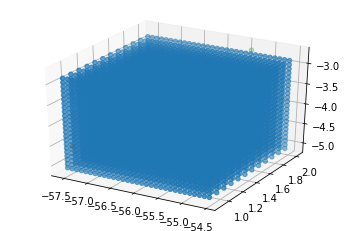

In [14]:

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(world_coords[:,0],world_coords[:,1],world_coords[:,2])
g=prism['g_triangle']
ax.scatter(g[:,0],g[:,1],g[:,2])
w=prism['w_triangle']
ax.scatter(w[:,0],w[:,1],w[:,2])

0.16296863555908203
0.15536236763000488
0.18627309799194336
0.1907331943511963
0.13355302810668945
0.1505424976348877
0.14462971687316895
0.137678861618042
0.1981053352355957
0.15539336204528809
0.16439270973205566
0.14194297790527344
0.17474913597106934
0.13811850547790527
0.13878154754638672
0.12502026557922363
0.15850234031677246
0.20100808143615723
0.15047430992126465
0.14403820037841797
0.19357728958129883


/home/kwagstyl/anaconda2/envs/padl/lib/python3.7/site-packages/ipykernel_launcher.py:115: ComplexWarning: Casting complex values to real discards the imaginary part


0.2548861503601074
0.22644948959350586
0.16535353660583496
0.15536141395568848
0.20332050323486328
0.15500140190124512
0.18393540382385254
0.13977789878845215
0.14026451110839844
0.1464371681213379
0.09307622909545898
0.10117483139038086
0.12093734741210938
0.11409831047058105
0.0932457447052002
0.13695693016052246
0.15106940269470215
0.14400959014892578
0.13361573219299316
0.09365582466125488
0.12168526649475098
0.12801504135131836
0.12937331199645996
0.08718705177307129
0.14718842506408691
0.11445474624633789
0.08187556266784668
0.08032965660095215
0.092193603515625
0.07218694686889648
0.0838921070098877
0.08716773986816406
0.13920164108276367
0.08725857734680176
0.14042139053344727
0.07706475257873535
0.07627201080322266
0.10963320732116699
0.12106060981750488
0.10854005813598633
0.15697789192199707
0.15823578834533691
0.20239925384521484
0.2902946472167969
0.20430707931518555
0.22969961166381836
0.21964597702026367
0.21739578247070312
0.3389730453491211
0.3707261085510254
0.3096525

KeyboardInterrupt: 

In [38]:
block[vc[:,0],vc[:,1],vc[:,2]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [41]:
block[vc[:].T]

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [396]:
vertices=np.array([[0,0,-1],
                   [0,1,0],
                   [0,0,1]])
find_nearest_point_on_triangle(point,vertices)

(1.25, 0.0, -0.25)

In [310]:
ind=np.random.randint(0,len(w_surf['faces']))
triangle=w_surf['faces'][ind]
prism1=generate_prism(g_surf['coords'], w_surf['coords'],triangle)
vector= (prism1['w_triangle']-prism1['g_triangle'])/100
normals=np.zeros((101,3))
depths=[]
for k in range(101):
    triangle=prism1['g_triangle']+vector*k
    depths.append(get_exact_depth(triangle[0],prism1)-k/100)
    #normals[k]=np.cross(triangle[1]-triangle[0],triangle[2]-triangle[0])/np.linalg.norm(np.cross(triangle[1]-triangle[0],triangle[2]-triangle[0]))
    
norm_diff=(normals[-1]-normals[0])/99
interpolated_normals=np.vstack((np.arange(100),np.arange(100),np.arange(100))).T*norm_diff+normals[0]


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [330]:
depths=[]
for k in range(101):
    triangle=prism1['g_triangle']+vector*k
    depths.append(get_exact_depth(triangle[0],prism1)-k/100)
  

In [316]:
print(prism1['w_triangle'],prism1['g_triangle'])

[[-20.1391   59.8926    7.51876]
 [-20.2672   60.1381    7.26101]
 [-20.3738   60.5669    7.84611]] [[-18.7694   61.1509    7.11433]
 [-18.9147   61.3576    6.7782 ]
 [-18.7677   61.5546    7.82171]]


In [331]:
depths

[array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array

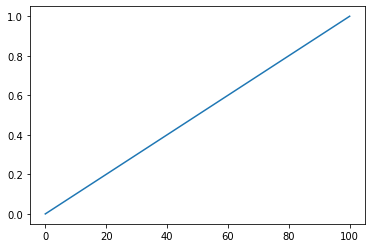

In [329]:
plt.plot(depths)

In [107]:
print(triangle,prism['w_triangle'])

[[-49.1209    3.24894   1.62829]
 [-48.4635    2.99372   2.27014]
 [-49.0948    3.41248   1.74374]] [[-49.1209    3.24894   1.62829]
 [-48.4635    2.99372   2.27014]
 [-49.0948    3.41248   1.74374]]


In [128]:
gray_inplane_vectors = np.array([prism['g_triangle'][2]-prism['g_triangle'][0],
                                     prism['g_triangle'][1]-prism['g_triangle'][0]])
cross_product_gray_inplane_vectors = np.cross(gray_inplane_vectors[1],gray_inplane_vectors[0])


[-0.50795972 -0.44802018  0.35725182]


In [194]:
get_exact_depth(triangle[0],prism1)

array([-9.8494868 , -0.20247424,  0.11722493])

In [187]:
np.dot(cross_product_gray_inplane_vectors,g3-voxel_coord)

26.176639646103254

In [188]:
np.dot(cross_product_gray_inplane_vectors,g3)+ -np.dot(cross_product_gray_inplane_vectors,voxel_coord)

26.176639646103254

In [181]:
np.roots([k0,k1,k2,k3])[0]

(0.5476650386412156+0j)

In [64]:
#ToDo, check for specific ks.
np.cross(connecting_inplane_vectors[0],connecting_inplane_vectors[1])

array([-0.00097954, -0.05834028,  0.03905579])

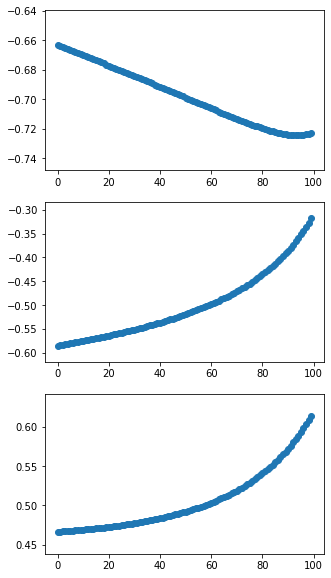

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(5,10))
plt.subplot(3,1,1)
plt.scatter(np.arange(100),normals[:,0])
plt.subplot(3,1,2)
plt.scatter(np.arange(100),normals[:,1])
plt.subplot(3,1,3)
plt.scatter(np.arange(100),normals[:,2])

In [122]:

world_coords, voxel_coords= voxel_world_coords_in_box(bbox,origin_offset, resolution, dimensions)

In [123]:
voxel_coords

array([[[[589, 632, 632],
         [590, 632, 632],
         [591, 632, 632],
         [592, 632, 632],
         [593, 632, 632],
         [594, 632, 632],
         [595, 632, 632],
         [596, 632, 632],
         [597, 632, 632],
         [598, 632, 632],
         [599, 632, 632],
         [600, 632, 632],
         [601, 632, 632],
         [602, 632, 632],
         [603, 632, 632],
         [604, 632, 632],
         [605, 632, 632],
         [606, 632, 632],
         [607, 632, 632],
         [608, 632, 632],
         [609, 632, 632],
         [610, 632, 632]]]])

In [53]:

np.ceil((bbox[0]-origin_offset)/resolution)
np.floor((bbox[1]-origin_offset)/resolution)

array([548., 461., 732.])

In [57]:
indices_max = np.max((np.min((np.floor((bbox[1]- origin_offset)/resolution), dimensions), axis=0),[0,0,0]), axis=0)
indices_min = np.min((np.max((np.ceil((bbox[0] - origin_offset)/resolution),[0,0,0]),axis=0),dimensions),axis=0)


In [63]:
np.mgrid[indices_max,indices_min]

AttributeError: 'numpy.ndarray' object has no attribute 'step'

In [69]:
np.mgrid[indices_min[0]:indices_max[0],
         indices_min[1]:indices_max[1],
        indices_min[1]:indices_max[1]].T

array([[[[538., 446., 446.],
         [539., 446., 446.],
         [540., 446., 446.],
         ...,
         [545., 446., 446.],
         [546., 446., 446.],
         [547., 446., 446.]],

        [[538., 447., 446.],
         [539., 447., 446.],
         [540., 447., 446.],
         ...,
         [545., 447., 446.],
         [546., 447., 446.],
         [547., 447., 446.]],

        [[538., 448., 446.],
         [539., 448., 446.],
         [540., 448., 446.],
         ...,
         [545., 448., 446.],
         [546., 448., 446.],
         [547., 448., 446.]],

        ...,

        [[538., 458., 446.],
         [539., 458., 446.],
         [540., 458., 446.],
         ...,
         [545., 458., 446.],
         [546., 458., 446.],
         [547., 458., 446.]],

        [[538., 459., 446.],
         [539., 459., 446.],
         [540., 459., 446.],
         ...,
         [545., 459., 446.],
         [546., 459., 446.],
         [547., 459., 446.]],

        [[538., 460., 446.],
       